## 2022년 4월 8일 스터디
**Dacon - 전복 나이 예측 경진대회 - EDA_데이터 분석 입문자를 위한 데이터 살펴보기, Baseline_RandomForest 를 이용한 정형 데이터 분류**

2022/3/31 목주영

- 커널 링크 : https://dacon.io/competitions/official/235877/codeshare/4695?page=1&dtype=recent
    - : https://dacon.io/competitions/official/235877/codeshare/4694?page=1&dtype=recent
    - : https://dacon.io/competitions/official/235877/codeshare/4712?page=1&dtype=recent
- 데이터 링크: https://dacon.io/competitions/official/235877/data
    - 위 링크로 들어가 전복 데이터 다운받기
- 학습 방법 :베이스라인 코드 참고하여 ML 모델 코딩해서 submit하기

#### 데이터 설명
1. train.csv : 학습 데이터
* id : 샘플 아이디
* Gender : 전복 성별
* Lenght : 전복 길이
* Diameter : 전복 둘레
* Height : 전복 키 
* Whole : Weight : 전복 전체 무게
* Shucked Weight : 껍질을 제외한 무게
* Viscra Weight : 내장 무게
* Shell Weight : 껍질 무게
* Target : 전복 나이


2. test.csv : 테스트 데이터
* id : 샘플 아이디
* Gender : 전복 성별
* Lenght : 전복 길이
* Diameter : 전복 둘레
* Height : 전복 키 
* Whole : Weight : 전복 전체 무게
* Shucked Weight : 껍질을 제외한 무게
* Viscra Weight : 내장 무게
* Shell Weight : 껍질 무게


3. sample_submissoin.csv : 제출 양식
* id : 샘플 아이디
* Target : 전복 나이


# 1. EDA

## 데이터 불러오기 전처리

### 데이터 불러오기

먼저 주어진 데이터를 불러오고 확인합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from collections import Counter # Outlier detection에서 사용

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train = pd.read_csv('data/train.csv')  # 다운받은 csv를 pandas의 DataFrame 형식으로 불러옵니다.
test = pd.read_csv('data/test.csv')

In [3]:
train.head() # 데이터 상위 5개를 확인합니다.

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,1,M,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15
1,2,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8
2,3,I,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18
3,4,M,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13
4,5,I,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6


In [4]:
test.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight
0,1,F,0.595,0.470,0.155,1.121,0.4515,0.1780,0.1550
1,2,M,0.580,0.450,0.150,0.927,0.2760,0.1815,0.3600
2,3,I,0.260,0.205,0.070,0.097,0.0415,0.0190,0.0305
3,4,M,0.590,0.460,0.130,1.102,0.4550,0.2055,0.3300
4,5,F,0.595,0.465,0.140,1.113,0.5175,0.2440,0.3050


In [5]:
train.shape # 데이터를 모양을 확인합니다.

(1253, 10)

데이터를 보아하니 10개의 열과 1253개의 행을 가진 데이터 입니다.

고유번호인 id를 제외하면 8가지의 피쳐와 1가지의 타겟이 존재합니다.

피쳐에는 카테고리형 데이터 Gender와 나머지 수치형 데이터 7가지가 존재합니다.

In [6]:
test.shape

(2924, 9)

## 데이터 결측치 확인

결측치(NA: Not Available)란 값이 누락된 데이터를 말합니다.

보다 정확한 분석을 하기 위해서는 데이터의 결측치를 확인하고 적절히 처리해주어야 합니다.

데이터에 결측치가 있는지 확인해보도록 하겠습니다.

In [7]:
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)
missing_col = check_missing_col(test)

결측치가 존재하지 않습니다
결측치가 존재하지 않습니다


결측치가 존재하지 않습니다.

별도의 결측치 처리는 하지 않아도 되겠습니다.

## 데이터의 고유번호 id 값 처리

데이터를 살펴보면 고유번호 id 값이 존재하는 것을 확인할 수 있습니다.

id 값은 기본적으로 인덱스(데이터의 위치를 포함하는 자료 구조)이기 때문에 분석을 할 때는 데이터의 위치를 필요로 하지 않습니다.

따라서 데이터프레임에서 id 값을 제거를 해줍니다.

In [8]:
train.columns[0]

'id'

In [9]:
if (train.columns[0]=='id'):
    train = train.drop(columns=['id'],axis=1) # id 열을 제거해 줍니다.
    
if (test.columns[0]=='id'):
    test = test.drop(columns=['id'],axis=1)

In [10]:
train.head()

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,M,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15
1,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8
2,I,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18
3,M,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13
4,I,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6


In [11]:
test.head()

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight
0,F,0.595,0.470,0.155,1.121,0.4515,0.1780,0.1550
1,M,0.580,0.450,0.150,0.927,0.2760,0.1815,0.3600
2,I,0.260,0.205,0.070,0.097,0.0415,0.0190,0.0305
3,M,0.590,0.460,0.130,1.102,0.4550,0.2055,0.3300
4,F,0.595,0.465,0.140,1.113,0.5175,0.2440,0.3050


## Target(나이) 분포 확인

데이터에서 Target(나이)의 분포를 살펴보겠습니다.

Target의 데이터 값이 무엇이 있는지 unique() 메소드를 통하여 확인해보겠습니다.

In [12]:
temp = train['Target'].unique() # Target의 중복되지 않은 값을 출력합니다.
np.sort(temp) # 오름차순으로 정렬합니다.

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 29], dtype=int64)

나이가 3세 ~ 23세 까지 그리고 29세가 데이터에 존재하는 것을 확인하였습니다.

그렇다면 Target 분포의 특성을 알기 위하여 나이 별 전복의 개수를 알아보겠습니다.

In [13]:
train.groupby('Target').count().iloc[:,0] # Target 값 별로 데이터의 개수를 세어줍니다.

Target
3       5
4      14
5      37
6      88
7     107
8     174
9     200
10    202
11    141
12     79
13     62
14     42
15     26
16     21
17     13
18     12
19      8
20     11
21      5
22      2
23      3
29      1
Name: Gender, dtype: int64

수치를 보면 10살이 202개로 가장 많은 것을 확인할 수 있습니다. 

수치로 한눈에 알아보기 힘드므로 그래프를 그려보겠습니다.

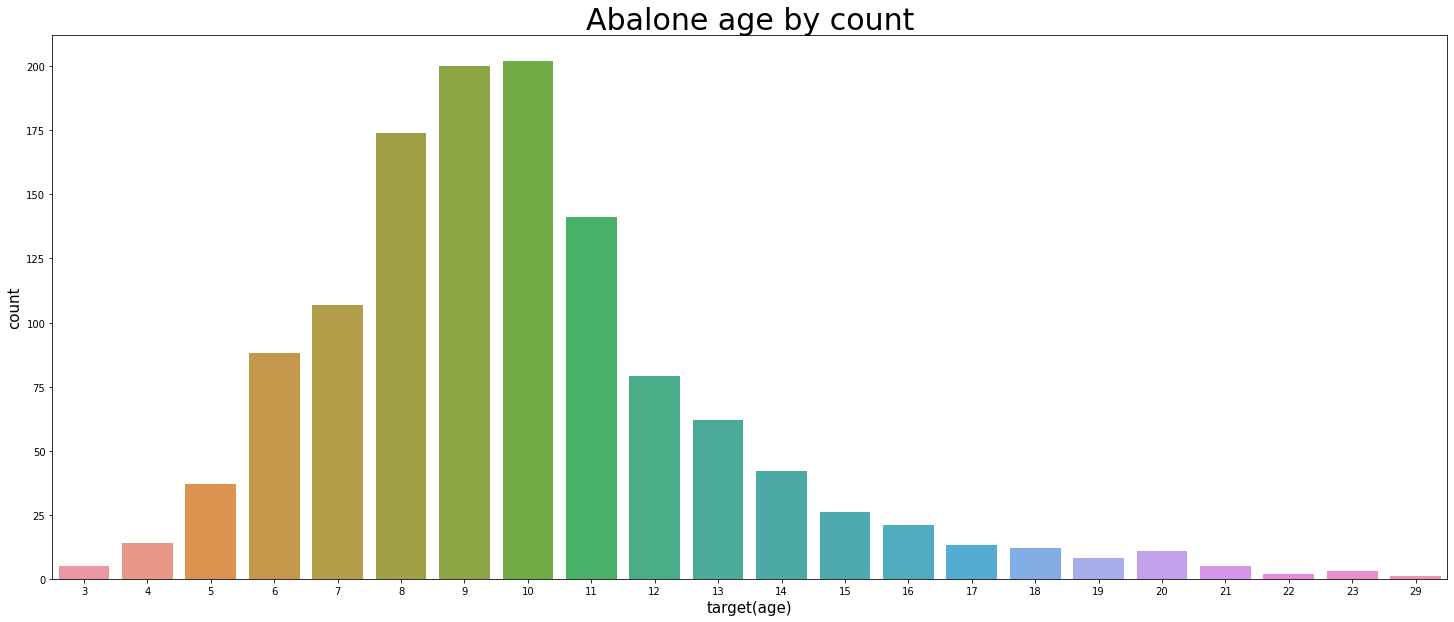

In [14]:
# 전복의 나이 분포 시각화
plt.rcParams['figure.figsize'] = [25,10]
sns.countplot('Target' , data=train)
plt.title('Abalone age by count', fontsize=30)
plt.xlabel('target(age)', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.show()

9~10세를 중심으로 분포를 형성되어있는 것을 확인 할 수 있습니다.

극단적으로 데이터를 비교해보면 가장 나이가 많은 23, 29세와 가장 나이가 적은 3세의 데이터를 데이터프레임 상으로 나타내보겠습니다.

In [15]:
temp1 = train['Target'] == 29
temp2 = train['Target'] == 23
train[temp1 | temp2] # 가장 나이가 많은 29세와 23세의 데이터 프레임을 합쳐서 보겠습니다.

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
553,F,0.45,0.380,0.165,0.8165,0.2500,0.1915,0.265,23
762,F,0.70,0.585,0.185,1.8075,0.7055,0.3215,0.475,29
1131,F,0.55,0.415,0.135,0.7750,0.3020,0.1790,0.260,23
1234,F,0.49,0.385,0.150,0.7865,0.2410,0.1400,0.240,23


In [16]:
train[train['Target'] == 3] # 가장 나이가 작은 3세의 데이터 프레임을 보겠습니다.

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
20,M,0.155,0.11,0.040,0.0155,0.0065,0.003,0.005,3
210,I,0.195,0.15,0.045,0.0375,0.0180,0.006,0.011,3
285,I,0.130,0.10,0.030,0.0130,0.0045,0.003,0.004,3
463,I,0.110,0.09,0.030,0.0080,0.0025,0.002,0.003,3
1013,I,0.180,0.13,0.045,0.0275,0.0125,0.010,0.009,3


데이터 프레임 상으로도 23,29세에 비하여 3세의 전복이 전반적으로 수치가 낮은 것을 확인해 볼 수 있습니다.

또한 Gender가 23, 29세인 전복이 모두 F이므로 Gender 분포를 확인해보도록 하겠습니다.

Gender는 카테고리형 변수 이므로 따로 데이터를 시각화 해보도록 하겠습니다.

In [17]:
# 전체의 데이터 타입을 확인
train.dtypes

Gender             object
Lenght            float64
Diameter          float64
Height            float64
Whole Weight      float64
Shucked Weight    float64
Viscra Weight     float64
Shell Weight      float64
Target              int64
dtype: object

# 데이터 기초 통계 분석

## 카테고리형 데이터 Gender 시각화

Gender의 데이터 값이 무엇이 있는지 unique() 메소드를 통하여 확인해보겠습니다.

In [18]:
print(train['Gender'].unique()) # Gender의 중복되지 않은 값을 출력합니다.

['M' 'I' 'F']


전복은 일반적으로 사람의 양성 체계와는 다르게,

성별이 M, I, F 로 세개로 나뉘어져 있군요!

그렇다면 Gender 각 성별의 데이터 개수를 확인해보도록 하겟습니다.

In [19]:
train.groupby('Gender').count().iloc[:,0]

Gender
F    380
I    404
M    469
Name: Lenght, dtype: int64

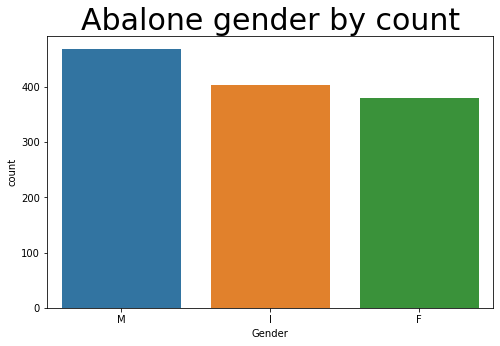

In [20]:
# 성별 데이터 개수 그래프
plt.rcParams['figure.figsize'] = [8,5]
sns.countplot('Gender', data=train)
plt.title('Abalone gender by count', fontsize=30)
plt.show()

데이터에서 M성별이 가장 많고 F성별이 가장 적은 것을 확인하였습니다.

다음으로 성별별로 나이의 분포를 살펴보겠습니다.

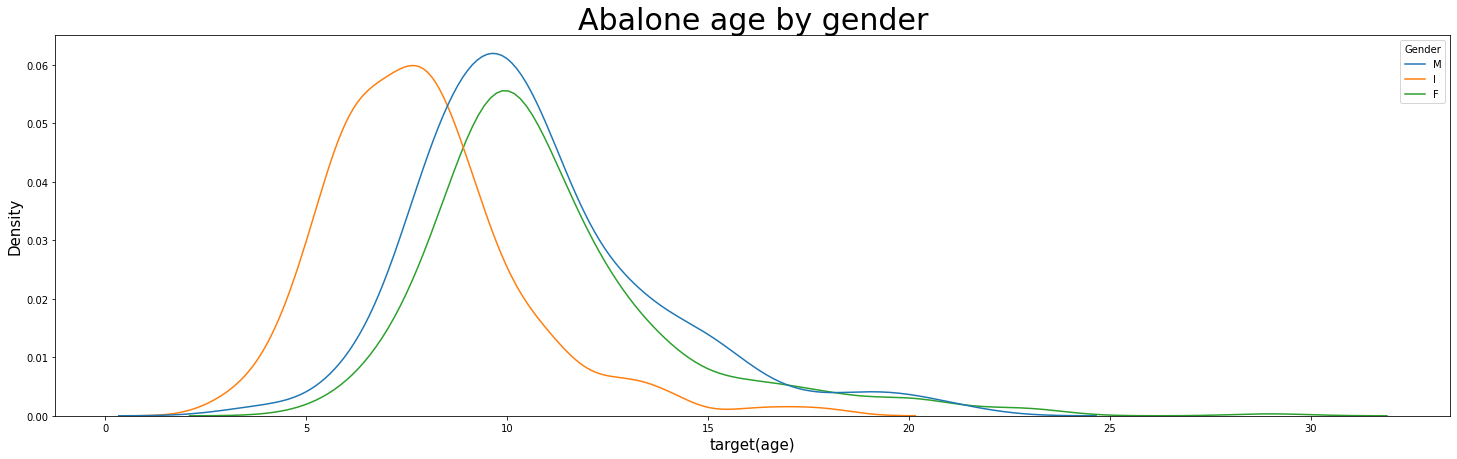

In [21]:
# 성별에 따른 나이 분포 그래프
plt.rcParams['figure.figsize'] = [25,7]
sns.kdeplot('Target', hue='Gender', data=train)
plt.title('Abalone age by gender', fontsize=30)
plt.xlabel('target(age)', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()

성별에 따른 나이 분포를 보면

I가 가장 왼쪽으로 치우쳐져 있는 것을 보아 세개의 성별중 가장 적은 나이를 살고 있고

그 다음으로 M, F 순으로 오래 사는 것을 확인해 볼 수 있습니다.

## 수치형 데이터 시각화

이제 수치형 데이터의 통계치를 알아보겠습니다.

pandas의 DataFrame은 describe이라는 메소드를 통해 각 컬럼의 평균값, 최대치, 최소치, 편차 등을 알아보겠습니다.

In [22]:
data_description = train.describe()
data_description

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
count,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000
mean,0.522869,0.406963,0.139545,0.831199,0.358818,0.181006,0.240077,9.912211
std,0.120231,0.099771,0.039033,0.500491,0.224612,0.111936,0.142574,3.214676
min,0.110000,0.090000,0.030000,0.008000,0.002500,0.002000,0.003000,3.000000
25%,0.445000,0.345000,0.115000,0.440500,0.182500,0.092500,0.130000,8.000000
50%,0.535000,0.420000,0.140000,0.777500,0.326000,0.168000,0.230000,10.000000
75%,0.615000,0.480000,0.165000,1.160000,0.505500,0.256500,0.330000,11.000000
max,0.780000,0.630000,0.250000,2.779500,1.488000,0.760000,1.005000,29.000000


### 데이터 분포 확인하기

숫자로만 봐서는 분포를 가늠하기 힘듭니다

각각의 데이터 분포를 히스토그램으로 그려보겠습니다.

각 데이터의 히스토그램에 평균(빨강)과 중앙값(초록)을 선으로 표시해보겠습니다.

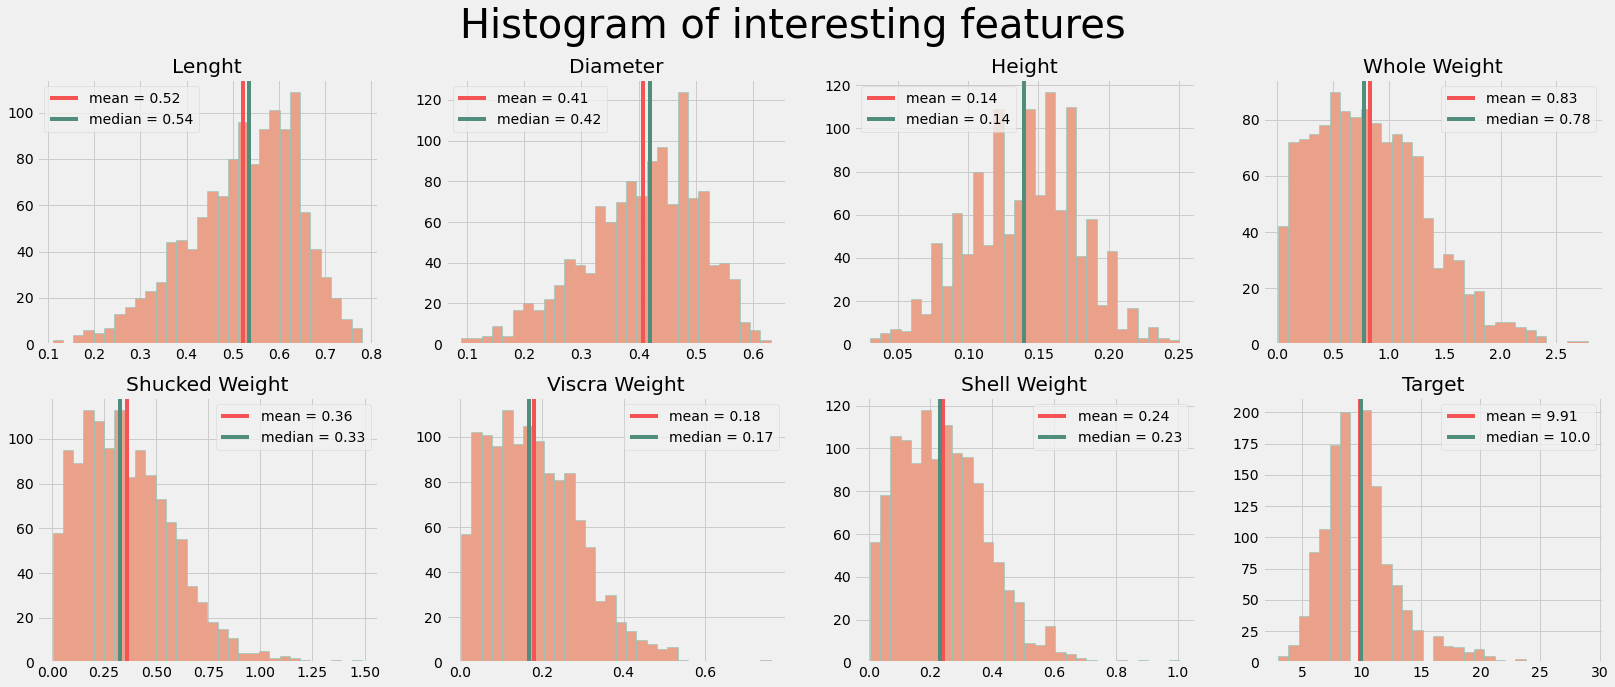

In [23]:
# 수치형 데이터 통계치 그래프
interest_coloumns = train.columns[1:]
plt.style.use('fivethirtyeight')
fig, ax =plt.subplots(2, 4, figsize = (25, 10))
fig.suptitle('Histogram of interesting features', fontsize=40)
column_idx = 0
for i in range(2):
    for j in range(4):
        ax[i][j].hist(train[interest_coloumns[column_idx]], bins=30, color='#eaa18a', edgecolor='#7bcabf')
        ax[i][j].set_title(interest_coloumns[column_idx])
        ax[i][j].axvline(data_description[interest_coloumns[column_idx]]['mean'], c='#f55354', label = f"mean = {round(data_description[interest_coloumns[column_idx]]['mean'], 2)}")
        ax[i][j].axvline(data_description[interest_coloumns[column_idx]]['50%'], c='#518d7d', label = f"median = {round(data_description[interest_coloumns[column_idx]]['50%'], 2)}")
        ax[i][j].legend()
        column_idx += 1

In [24]:
print('전복의 평균 나이는', round(data_description[interest_coloumns[7]]['mean'],1), '입니다') #round를 하여 소수점 1의 자리까지 반올림 하였습니다.

전복의 평균 나이는 9.9 입니다


Target을 보면 전복의 평균 나이는 약 9.9세라는 것을 알 수 있고

전복의 무게가 좌편향 되어있는 것을 보아

무게가 많이 나가는 전복들이 평균에 비하여 드물게 존재한다라는 인사이트를 얻을 수 있습니다.

### 타겟(나이)와 상관관계 확인하기

타겟인 나이와 나머지 변수들의 어떤 상관관계 있는지 확인 하기 위하여 

데이터를 이용하여 그래프를 그려보겠습니다.

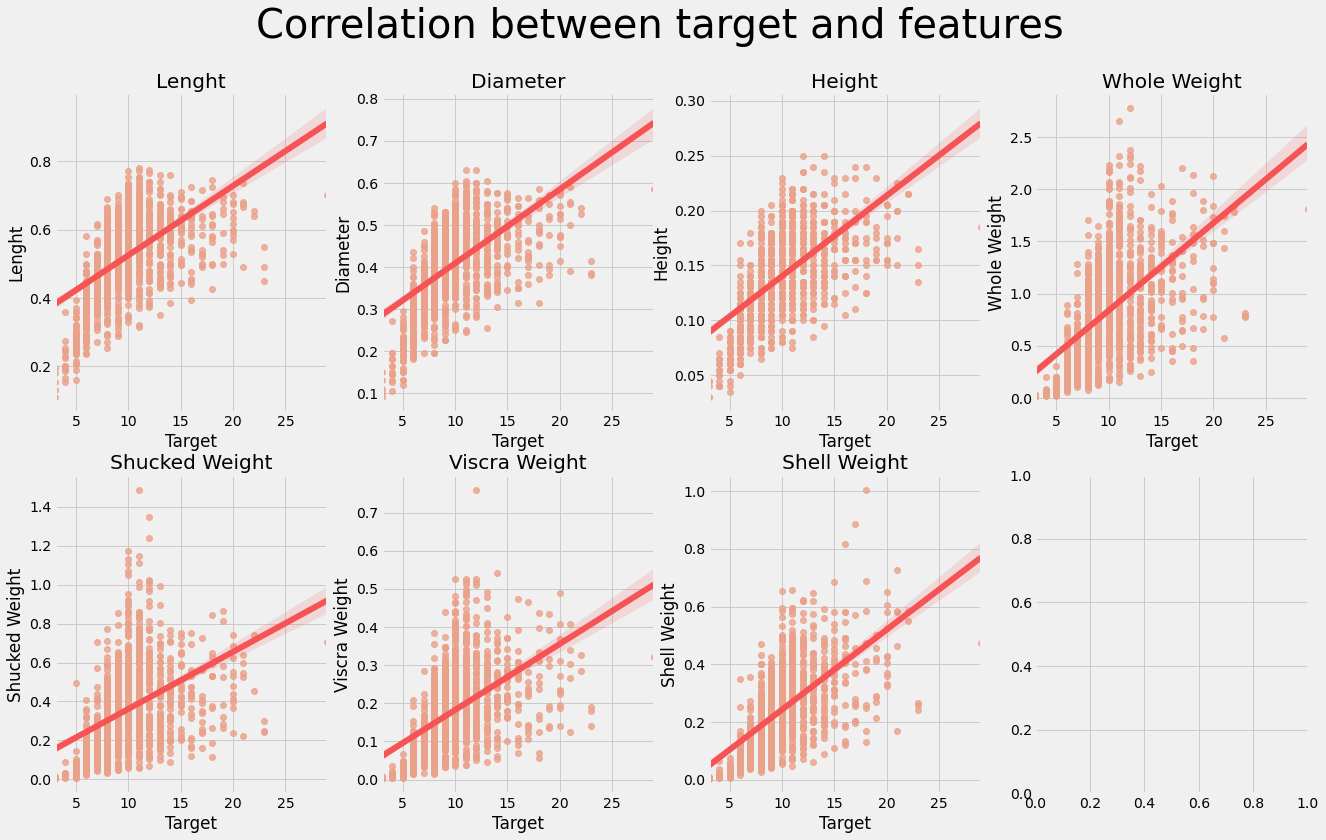

In [25]:
# 수치형 데이터 분포 Target과 상관관계 그래프
def visualize(axx, yfield):
  sns.regplot(x='Target', y=yfield, data=train,  color='#eaa18a', line_kws=  {'color': '#f55354'} , ax = axx) # regplot을 이용하여 추세선과 산점도 그래프를 그려줍니다.
  axx.set_title(yfield)

figure, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2, ncols=4)
figure.set_size_inches(20,12)
figure.suptitle('Correlation between target and features', fontsize=40)
for i in range(len(train.columns[1:-1])):
  visualize(eval(f'ax{i+1}'), train.columns[i+1])

그래프를 통하여 Target(age)와 Lenght, Diameter, Height, Whole Weight, Sucked Weight, Wiscra Weight, Shell Weight 피쳐들 관계의 추세선을 확인해 보아,

모두 왼쪽 위 방향을 향하고 있으므로 양의 상관관계를 가지고 있음을 도출하였습니다.

### 히트맵 그려보기

피어슨 상관관계 분석 방법을 이용하여,

feature들 간의 상관관계를 히트맵을 그려 어떤 컬럼들이 높은 상관관계를 갖는지 알아보겠습니다.

In [26]:
# 수치형 데이터 상관관계 히트맵 시각화
train_corr = train.drop(columns=['Gender'],axis=1)
scaler= MinMaxScaler() 
train_corr[train_corr.columns] = scaler.fit_transform(train_corr[train_corr.columns])
corr28 = train_corr.corr(method= 'pearson')

Text(0.5, 1.0, 'Correlation between features')

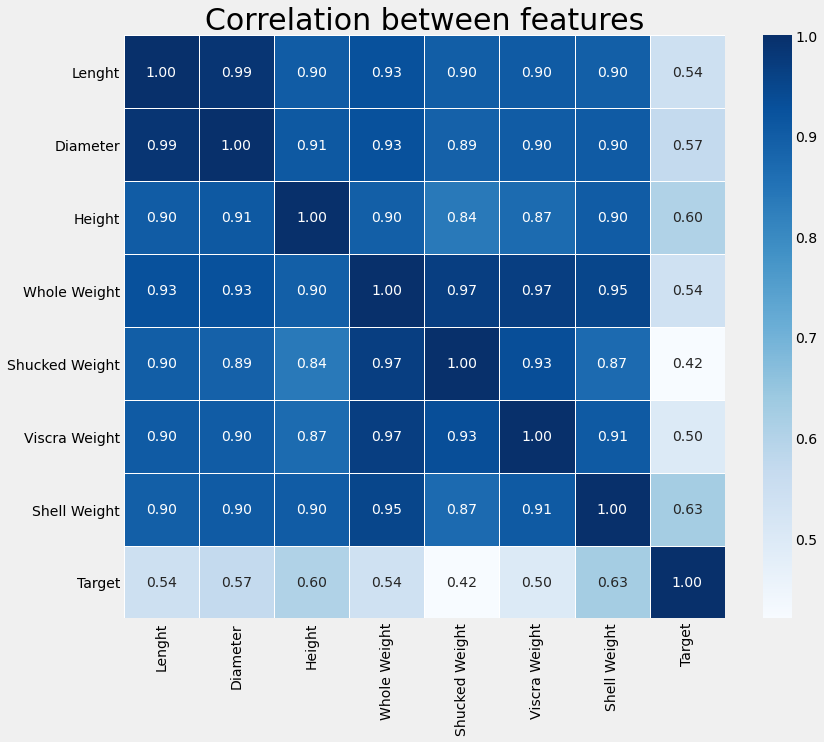

In [27]:
plt.figure(figsize=(12,10))
sns.heatmap(data = corr28, annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)

feature가 많아서 헷갈리니 Target과의 관계만을 살펴보겠습니다.



In [28]:
# Target과 피쳐들의 상관관계
s28 = corr28.unstack()
df_temp28 = pd.DataFrame(s28['Target'].sort_values(ascending=False), columns=['Target'])
df_temp28.style.background_gradient(cmap='viridis')

,Target
Target,1.000000
Shell Weight,0.625819
Height,0.604654
Diameter,0.567933
Lenght,0.543789
Whole Weight,0.538404
Viscra Weight,0.497283
Shucked Weight,0.420126


우리가 가장 관심있는 것은 전복의 나이와 어떤 컬럼이 가장 상관관계가 높은가 입니다.

그래프를 보니 shell Weight가 가장 높은 양의 상관관계가 있는것으로 나타났네요!

이는 나이가 많을수록 껍질의 무게가 무거워진다는 것으로 해석할 수 있겠습니다.

또한 상관계수가 0.3 이상이면 유의미한 양의 상관관계를 가진다고 해석할 수 있습니다.

그러므로 다른 피쳐들도 상관계수가 0.3 이상이기 때문에 나이가 많을 수록 높이, 지름 길이, 무게가 커진다는 결론을 도출 할 수 있겠습니다.

# 2. 데이터 전처리

## 이상치 감지

In [29]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Lenght","Diameter","Height", "Whole Weight", "Shucked Weight", "Viscra Weight", "Shell Weight"])

In [30]:
train.loc[Outliers_to_drop] # Show the outliers rows

,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
255,I,0.160,0.120,0.035,0.0210,0.0075,0.0045,0.0050,5
285,I,0.130,0.100,0.030,0.0130,0.0045,0.0030,0.0040,3
463,I,0.110,0.090,0.030,0.0080,0.0025,0.0020,0.0030,3
504,M,0.775,0.630,0.250,2.7795,1.3485,0.7600,0.5780,12
17,M,0.765,0.600,0.220,2.3020,1.0070,0.5090,0.6205,12
511,M,0.740,0.595,0.190,2.3235,1.1495,0.5115,0.5050,11


We detect 6 outliers.

In [31]:
# Drop outliers
#train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## 데이터 인코딩
머신러닝 알고리즘은 문자열 데이터 속성을 입력받지 않으며 모든 데이터는 숫자형으로 표현되어야 합니다.

그래서 문자형 카테고리형 속성은 모두 숫자 값으로 변환/인코딩 되어야 합니다.

우리 데이터에는 Gender라는 Feautre의 항목이 문자로 이루어져있기 때문에, 이것을 Encoding 해볼텐데요,

인코딩 방식에는 크게 'Label Encoding'과 'One-Hot Encoding'이 있습니다.

Label Encoding(범주형 변수의 문자열을 수치형으로 변환하는 방법)보다 One-Hot Encoding이 일반적으로 성능이 더 좋기 때문에 get_dummies 함수를 이용해 One-Hot Encoding을 사용해보겠습니다.

In [32]:
# convert to indicator values Gender
train = pd.get_dummies(train, columns = ['Gender'])
test = pd.get_dummies(test, columns = ['Gender'])

# pd.get_dummies: Convert categorical variable into dummy/indicator variables.

In [33]:
train.head()

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target,Gender_F,Gender_I,Gender_M
0,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15,0,0,1
1,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8,0,1,0
2,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18,0,1,0
3,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13,0,0,1
4,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6,0,1,0


In [34]:
test.head()

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Gender_F,Gender_I,Gender_M
0,0.595,0.470,0.155,1.121,0.4515,0.1780,0.1550,1,0,0
1,0.580,0.450,0.150,0.927,0.2760,0.1815,0.3600,0,0,1
2,0.260,0.205,0.070,0.097,0.0415,0.0190,0.0305,0,1,0
3,0.590,0.460,0.130,1.102,0.4550,0.2055,0.3300,0,0,1
4,0.595,0.465,0.140,1.113,0.5175,0.2440,0.3050,1,0,0


# 3. 모델 학습

본격적으로 모델 학습을 위해 학습 데이터와 Target을 분리합니다. 

In [35]:
X_train = train.drop(['Target'], axis=1)
y_train = train.Target

In [36]:
X_train.head()

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Gender_F,Gender_I,Gender_M
0,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,0,0,1
1,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,0,1,0
2,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,0,1,0
3,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,0,0,1
4,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,0,1,0


In [37]:
y_train.head()

0    15
1     8
2    18
3    13
4     6
Name: Target, dtype: int64

## 교차 검증(cross validation)

I compared 9 popular regressors and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure.

* SVR
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* LinearRegression

In [38]:
pip install --upgrade ngboost

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: autograd>=1.3 in c:\users\mok\anaconda3\lib\site-packages (from lifelines>=0.25->ngboost) (1.3)



You should consider upgrading via the 'C:\Users\MOK\anaconda3\python.exe -m pip install --upgrade pip' command.


In [39]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from ngboost import NGBRegressor

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, learning_curve

In [40]:
# Cross validate model with Kfold cross val
kfold = KFold(n_splits=10)

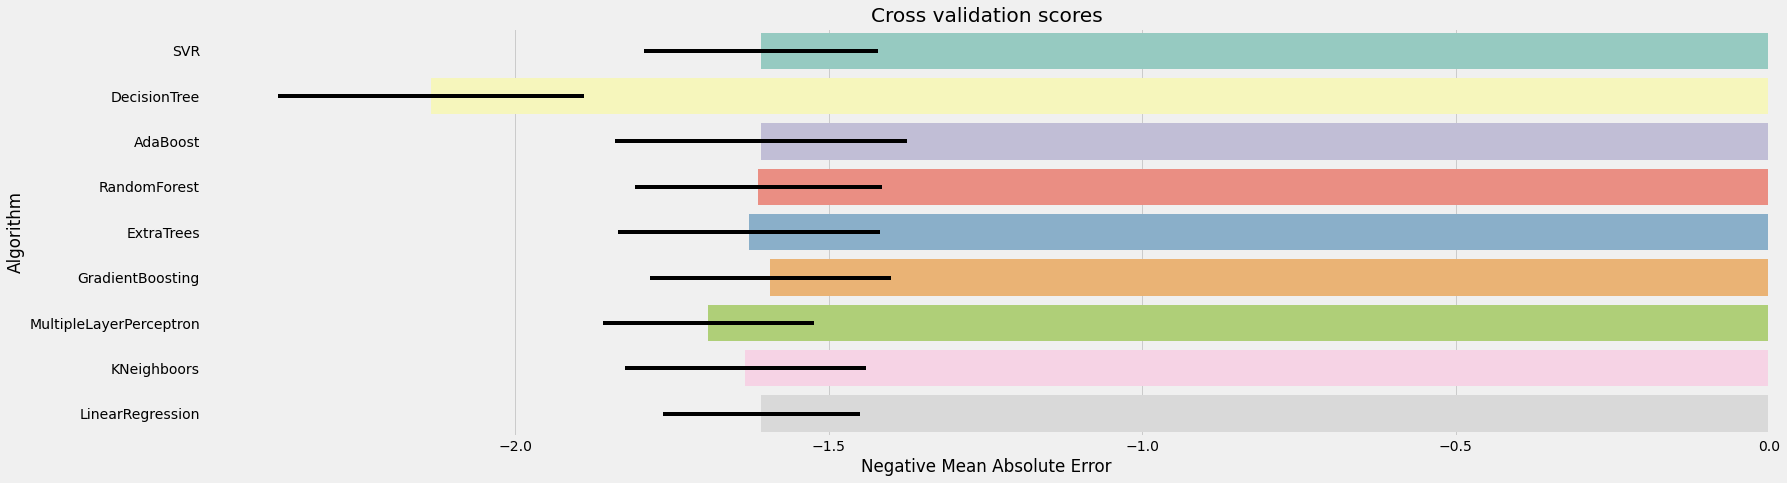

In [41]:
#모델들을 할당할 리스트를 만들어줍니다.
random_state = 42
models = []

#모델들을 각각 할당하여 리스트에 추가합니다.
models.append(SVR())
models.append(DecisionTreeRegressor(random_state=random_state))
models.append(AdaBoostRegressor(DecisionTreeRegressor(random_state=random_state),random_state=random_state,learning_rate=0.1))
models.append(RandomForestRegressor(random_state=random_state))
models.append(ExtraTreesRegressor(random_state=random_state))
models.append(GradientBoostingRegressor(random_state=random_state))
models.append(MLPRegressor(random_state=random_state))
models.append(KNeighborsRegressor())
models.append(LinearRegression())

cv_results = []
for model in models :
    cv_results.append(cross_val_score(model, X_train, y = y_train, scoring = 'neg_mean_absolute_error', cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVR","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors", "LinearRegression"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Negative Mean Absolute Error")
g = g.set_title("Cross validation scores")


#https://scikit-learn.org/stable/modules/model_evaluation.html

In [42]:
#모델들을 할당한 리스트를 불러와 순차적으로 train 데이터에 학습을 시켜줍니다.
#for model in models:
    #model.fit(X_train, y_train) # 모델 학습

#for model in models:
    #print(model, "\n->", model.score(X_train, y_train))

In [43]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [44]:
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    print(model, "\n->", NMAE(y_train, y_pred))

SVR() 
-> 0.840666331930396
DecisionTreeRegressor(random_state=42) 
-> 1.0
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=42),
                  learning_rate=0.1, random_state=42) 
-> 0.9999194847020934
RandomForestRegressor(random_state=42) 
-> 0.9401489533011274
ExtraTreesRegressor(random_state=42) 
-> 1.0
GradientBoostingRegressor(random_state=42) 
-> 0.8772745892803955
MLPRegressor(random_state=42) 
-> 0.8308617372053845
KNeighborsRegressor() 
-> 0.8633333333333331
LinearRegression() 
-> 0.8392981712795369


C:\Users\MOK\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


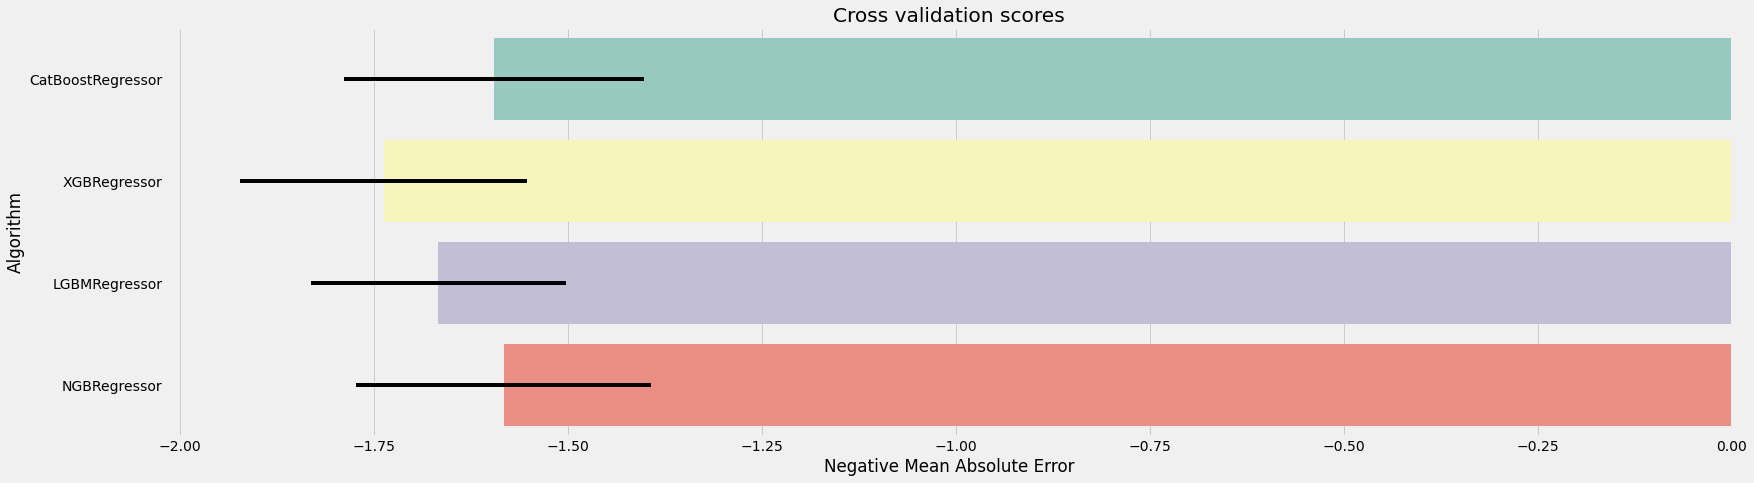

In [45]:
models2 = []

models2.append(CatBoostRegressor())
models2.append(XGBRegressor(random_state=random_state))
models2.append(LGBMRegressor(random_state=random_state))
models2.append(NGBRegressor(random_state=random_state))

cv_results = []
for model in models2 :
    cv_results.append(cross_val_score(model, X_train, y = y_train, scoring = 'neg_mean_absolute_error', cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["CatBoostRegressor","XGBRegressor","LGBMRegressor",
"NGBRegressor"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Negative Mean Absolute Error")
g = g.set_title("Cross validation scores")

In [46]:
for model in models2:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    print(model, "\n->", 1-NMAE(y_train, y_pred))

Learning rate set to 0.042428
0:	learn: 3.1638355	total: 140ms	remaining: 2m 19s
1:	learn: 3.1168176	total: 142ms	remaining: 1m 10s
2:	learn: 3.0747941	total: 144ms	remaining: 47.8s
3:	learn: 3.0358514	total: 146ms	remaining: 36.4s
4:	learn: 3.0038837	total: 148ms	remaining: 29.5s
5:	learn: 2.9645248	total: 150ms	remaining: 24.9s
6:	learn: 2.9287151	total: 152ms	remaining: 21.6s
7:	learn: 2.8933952	total: 154ms	remaining: 19.1s
8:	learn: 2.8640193	total: 157ms	remaining: 17.2s
9:	learn: 2.8303260	total: 158ms	remaining: 15.7s
10:	learn: 2.8042021	total: 160ms	remaining: 14.4s
11:	learn: 2.7757848	total: 162ms	remaining: 13.3s
12:	learn: 2.7525932	total: 164ms	remaining: 12.4s
13:	learn: 2.7292853	total: 167ms	remaining: 11.8s
14:	learn: 2.7026974	total: 170ms	remaining: 11.2s
15:	learn: 2.6802522	total: 173ms	remaining: 10.6s
16:	learn: 2.6594760	total: 175ms	remaining: 10.1s
17:	learn: 2.6409495	total: 177ms	remaining: 9.68s
18:	learn: 2.6242116	total: 179ms	remaining: 9.24s
19:	learn

195:	learn: 1.8883894	total: 485ms	remaining: 1.99s
196:	learn: 1.8876265	total: 487ms	remaining: 1.98s
197:	learn: 1.8850231	total: 489ms	remaining: 1.98s
198:	learn: 1.8835165	total: 491ms	remaining: 1.98s
199:	learn: 1.8819792	total: 493ms	remaining: 1.97s
200:	learn: 1.8805026	total: 494ms	remaining: 1.96s
201:	learn: 1.8795054	total: 496ms	remaining: 1.96s
202:	learn: 1.8776861	total: 498ms	remaining: 1.95s
203:	learn: 1.8771399	total: 500ms	remaining: 1.95s
204:	learn: 1.8750727	total: 502ms	remaining: 1.95s
205:	learn: 1.8738311	total: 503ms	remaining: 1.94s
206:	learn: 1.8718507	total: 505ms	remaining: 1.94s
207:	learn: 1.8684530	total: 507ms	remaining: 1.93s
208:	learn: 1.8669600	total: 509ms	remaining: 1.93s
209:	learn: 1.8639375	total: 511ms	remaining: 1.92s
210:	learn: 1.8614457	total: 513ms	remaining: 1.92s
211:	learn: 1.8603574	total: 514ms	remaining: 1.91s
212:	learn: 1.8586968	total: 516ms	remaining: 1.91s
213:	learn: 1.8567484	total: 518ms	remaining: 1.9s
214:	learn: 1

412:	learn: 1.5668848	total: 946ms	remaining: 1.34s
413:	learn: 1.5663496	total: 948ms	remaining: 1.34s
414:	learn: 1.5644611	total: 950ms	remaining: 1.34s
415:	learn: 1.5630059	total: 952ms	remaining: 1.34s
416:	learn: 1.5610925	total: 954ms	remaining: 1.33s
417:	learn: 1.5593444	total: 956ms	remaining: 1.33s
418:	learn: 1.5578587	total: 958ms	remaining: 1.33s
419:	learn: 1.5573986	total: 960ms	remaining: 1.32s
420:	learn: 1.5555271	total: 962ms	remaining: 1.32s
421:	learn: 1.5546288	total: 963ms	remaining: 1.32s
422:	learn: 1.5530033	total: 965ms	remaining: 1.32s
423:	learn: 1.5524576	total: 967ms	remaining: 1.31s
424:	learn: 1.5504741	total: 969ms	remaining: 1.31s
425:	learn: 1.5495337	total: 971ms	remaining: 1.31s
426:	learn: 1.5489504	total: 973ms	remaining: 1.31s
427:	learn: 1.5468761	total: 975ms	remaining: 1.3s
428:	learn: 1.5457292	total: 977ms	remaining: 1.3s
429:	learn: 1.5435163	total: 980ms	remaining: 1.3s
430:	learn: 1.5428423	total: 982ms	remaining: 1.3s
431:	learn: 1.54

581:	learn: 1.3744700	total: 1.26s	remaining: 906ms
582:	learn: 1.3739927	total: 1.26s	remaining: 904ms
583:	learn: 1.3733185	total: 1.26s	remaining: 902ms
584:	learn: 1.3722794	total: 1.27s	remaining: 899ms
585:	learn: 1.3717667	total: 1.27s	remaining: 897ms
586:	learn: 1.3709550	total: 1.27s	remaining: 894ms
587:	learn: 1.3702598	total: 1.27s	remaining: 893ms
588:	learn: 1.3691279	total: 1.28s	remaining: 891ms
589:	learn: 1.3686774	total: 1.28s	remaining: 888ms
590:	learn: 1.3683447	total: 1.28s	remaining: 886ms
591:	learn: 1.3672033	total: 1.28s	remaining: 884ms
592:	learn: 1.3668403	total: 1.28s	remaining: 882ms
593:	learn: 1.3659550	total: 1.29s	remaining: 881ms
594:	learn: 1.3647144	total: 1.29s	remaining: 879ms
595:	learn: 1.3623121	total: 1.29s	remaining: 878ms
596:	learn: 1.3612226	total: 1.3s	remaining: 876ms
597:	learn: 1.3604981	total: 1.3s	remaining: 874ms
598:	learn: 1.3599024	total: 1.3s	remaining: 872ms
599:	learn: 1.3586896	total: 1.31s	remaining: 871ms
600:	learn: 1.3

805:	learn: 1.2105933	total: 1.73s	remaining: 416ms
806:	learn: 1.2100433	total: 1.73s	remaining: 414ms
807:	learn: 1.2093461	total: 1.73s	remaining: 412ms
808:	learn: 1.2085713	total: 1.74s	remaining: 411ms
809:	learn: 1.2067530	total: 1.74s	remaining: 409ms
810:	learn: 1.2056788	total: 1.75s	remaining: 407ms
811:	learn: 1.2056586	total: 1.75s	remaining: 405ms
812:	learn: 1.2049626	total: 1.75s	remaining: 403ms
813:	learn: 1.2038685	total: 1.75s	remaining: 401ms
814:	learn: 1.2029985	total: 1.76s	remaining: 399ms
815:	learn: 1.2020114	total: 1.76s	remaining: 397ms
816:	learn: 1.2014344	total: 1.76s	remaining: 395ms
817:	learn: 1.2009061	total: 1.77s	remaining: 393ms
818:	learn: 1.2001876	total: 1.77s	remaining: 391ms
819:	learn: 1.1992344	total: 1.77s	remaining: 389ms
820:	learn: 1.1990419	total: 1.77s	remaining: 387ms
821:	learn: 1.1977140	total: 1.78s	remaining: 385ms
822:	learn: 1.1969798	total: 1.78s	remaining: 383ms
823:	learn: 1.1959974	total: 1.78s	remaining: 381ms
824:	learn: 

-> 0.9172927874329819
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 
-> 0.9775391481348857
LGBMRegressor(random_state=42) 
-> 0.9121612536786599
[iter 0] loss=2.5863 val_loss=0.0000 scale=1.0000 norm=2.4917
[iter 100] loss=2.2294 val_loss=0.0000 scale=1.0000 norm=1.8517
[iter 200] loss=2.0447 val_loss=0.0000 scale=1.0000 norm=1.6419
[iter 300] loss=1.9290 val_loss=0.0000 scale=1.0000 norm=1.5582
[iter 400] loss=1.8744 val_loss=0.0000 scale=1.0000 norm=1.5127
NGBRegre

## 하이퍼파라미터 튜닝 (Hyperparameter tuning)

In [43]:
## MLPRegressor
mlp_reg = MLPRegressor(random_state=random_state)
mlp_param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

mlp_reg_grid = GridSearchCV(mlp_reg,param_grid = mlp_param_grid, cv=kfold, scoring="neg_mean_absolute_error", n_jobs= -1)

mlp_reg_grid.fit(X_train,y_train)

mlp_reg_best = mlp_reg_grid.best_estimator_
print(mlp_reg_best)

# Best score
print(mlp_reg_grid.best_score_)

MLPRegressor(hidden_layer_sizes=(120, 80, 40), max_iter=100, random_state=42)
-1.5983808719734125


C:\Users\MOK\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
## KNeighborsRegressor
knn_reg = KNeighborsRegressor()
knn_param_grid = dict(n_neighbors=list(range(1, 31)))

knn_reg_grid = GridSearchCV(knn_reg,param_grid = knn_param_grid, cv=kfold, scoring="neg_mean_absolute_error", n_jobs= -1)

knn_reg_grid.fit(X_train,y_train)

knn_reg_best = knn_reg_grid.best_estimator_
print(knn_reg_best)

# Best score
print(knn_reg_grid.best_score_)

KNeighborsRegressor(n_neighbors=12)
-1.6360983870967742


In [59]:
dt_reg = DecisionTreeRegressor(random_state=random_state)
dt_reg.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [62]:
# DecisionTreeRegressor


dt_param_grid = {'min_samples_split': range(2, 10),
                 'max_depth': [2, 4, 6, 8]}
            
            
dt_reg_grid = GridSearchCV(dt_reg,param_grid = dt_param_grid, cv=kfold, scoring="neg_mean_absolute_error", n_jobs= -1)

dt_reg_grid.fit(X_train,y_train)

dt_reg_best = dt_reg_grid.best_estimator_
print(dt_reg_best)

# Best score
print(dt_reg_grid.best_score_)

DecisionTreeRegressor(max_depth=4, random_state=42)
-1.76277997217626


In [47]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTR = DecisionTreeRegressor(random_state=random_state, max_depth = 5)

adaDTR = AdaBoostRegressor(DTR, random_state=random_state)

ada_param_grid = {"n_estimators" :[1,2,3,4,5,6,7,8,9],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTR = GridSearchCV(adaDTR, param_grid = ada_param_grid, cv=kfold, scoring="neg_mean_absolute_error", n_jobs= -1, verbose = 3)

gsadaDTR.fit(X_train,y_train)

ada_best = gsadaDTR.best_estimator_
print(ada_best)

Fitting 10 folds for each of 63 candidates, totalling 630 fits
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=5,
                                                       random_state=42),
                  learning_rate=0.001, n_estimators=9, random_state=42)


In [48]:
gsadaDTR.best_score_

-1.5673245112358918

In [49]:
#ExtraTrees 
ExtR = ExtraTreesRegressor()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300]}


gsExtR = GridSearchCV(ExtR,param_grid = ex_param_grid, cv=kfold, scoring="neg_mean_absolute_error", n_jobs= -1)

gsExtR.fit(X_train,y_train)

ExtR_best = gsExtR.best_estimator_
print(ExtR_best)

# Best score
print(gsExtR.best_score_)

ExtraTreesRegressor(max_features=10, min_samples_leaf=3, min_samples_split=10,
                    n_estimators=300)
-1.5543788747644407


In [50]:
# RF Parameters tunning 
RFR = RandomForestRegressor()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [1, 3, 5, 7],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300]}


gsRFR = GridSearchCV(RFR,param_grid = rf_param_grid, cv=kfold, scoring="neg_mean_absolute_error", n_jobs= -1)

gsRFR.fit(X_train,y_train)

RFR_best = gsRFR.best_estimator_
print(RFR_best)

# Best score
print(gsRFR.best_score_)

RandomForestRegressor(bootstrap=False, max_depth=7, max_features=3,
                      min_samples_leaf=10, min_samples_split=10,
                      n_estimators=300)
-1.5755717805473843


In [51]:
# Gradient boosting tunning

GBR = GradientBoostingRegressor()
gb_param_grid = {'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBR = GridSearchCV(GBR,param_grid = gb_param_grid, cv=kfold, scoring="neg_mean_absolute_error", n_jobs= -1, verbose = 3)

gsGBR.fit(X_train,y_train)

GBR_best = gsGBR.best_estimator_
print(GBR_best)

# Best score
print(gsGBR.best_score_)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
GradientBoostingRegressor(learning_rate=0.05, max_depth=8, max_features=0.3,
                          min_samples_leaf=100, n_estimators=200)
-1.6440080372300099


In [52]:
### SVC classifier
SVMR = SVR()
svr_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMR = GridSearchCV(SVMR,param_grid = svr_param_grid, cv=kfold, scoring="neg_mean_absolute_error", n_jobs= -1)

gsSVMR.fit(X_train,y_train)

SVMR_best = gsSVMR.best_estimator_
print(SVMR_best)

# Best score
print(gsSVMR.best_score_)

SVR(C=1000, gamma=0.1)
-1.5029567057569218


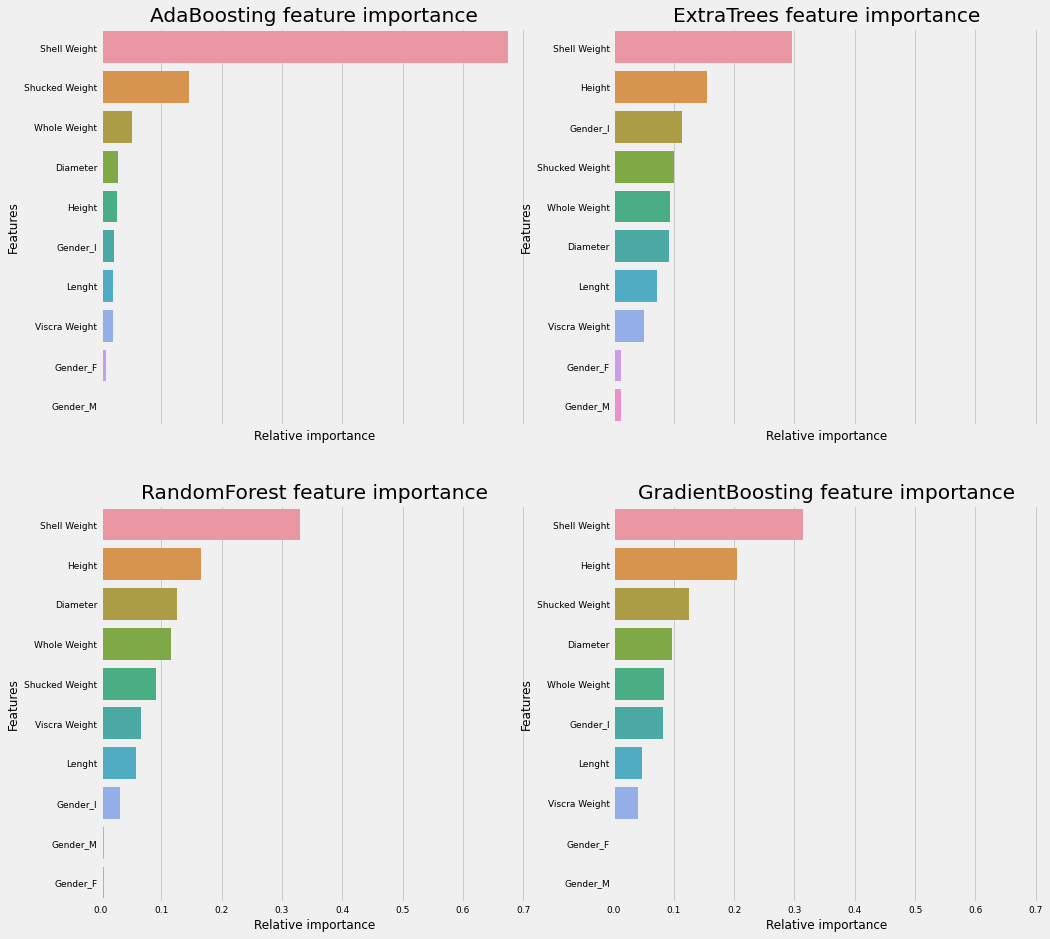

In [53]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_regressors = [("AdaBoosting", ada_best),("ExtraTrees",ExtR_best),("RandomForest",RFR_best),("GradientBoosting",GBR_best)]

nregressor = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressor][0]
        regressor = names_regressors[nregressor][1]
        indices = np.argsort(regressor.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = regressor.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nregressor += 1

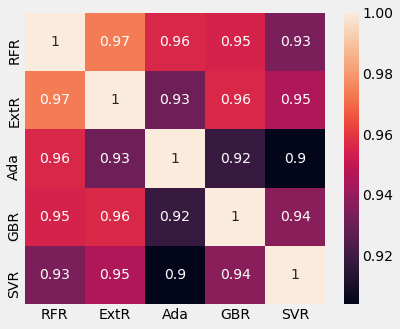

In [54]:
test_Survived_RFR = pd.Series(RFR_best.predict(test), name="RFR")
test_Survived_ExtR = pd.Series(ExtR_best.predict(test), name="ExtR")
test_Survived_SVMR = pd.Series(SVMR_best.predict(test), name="SVR")
test_Survived_AdaR = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBR = pd.Series(GBR_best.predict(test), name="GBR")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFR,test_Survived_ExtR,test_Survived_AdaR,test_Survived_GBR, test_Survived_SVMR],axis=1)

plt.figure(figsize=(6,5))
g= sns.heatmap(ensemble_results.corr(),annot=True)

### model2

In [56]:
## CatBoostRegressor
cbr_reg = CatBoostRegressor()
cbr_param_grid = {'iterations': [100,500,1000], 
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                  'depth': [4, 6, 10]}

cbr_reg_grid = GridSearchCV(cbr_reg,param_grid = cbr_param_grid, cv=kfold, scoring="neg_mean_absolute_error", n_jobs= -1)

cbr_reg_grid.fit(X_train,y_train)

cbr_reg_best = cbr_reg_grid.best_estimator_
print(cbr_reg_best)

# Best score
print(cbr_reg_grid.best_score_)

0:	learn: 3.2015978	total: 5.11ms	remaining: 5.1s
1:	learn: 3.1897909	total: 17.9ms	remaining: 8.94s
2:	learn: 3.1770459	total: 39.2ms	remaining: 13s
3:	learn: 3.1638173	total: 60.7ms	remaining: 15.1s
4:	learn: 3.1522598	total: 84ms	remaining: 16.7s
5:	learn: 3.1405275	total: 104ms	remaining: 17.3s
6:	learn: 3.1281445	total: 125ms	remaining: 17.8s
7:	learn: 3.1173876	total: 147ms	remaining: 18.2s
8:	learn: 3.1043380	total: 168ms	remaining: 18.5s
9:	learn: 3.0940161	total: 187ms	remaining: 18.5s
10:	learn: 3.0820260	total: 213ms	remaining: 19.2s
11:	learn: 3.0719789	total: 241ms	remaining: 19.9s
12:	learn: 3.0604209	total: 253ms	remaining: 19.2s
13:	learn: 3.0493969	total: 274ms	remaining: 19.3s
14:	learn: 3.0382511	total: 296ms	remaining: 19.4s
15:	learn: 3.0284515	total: 320ms	remaining: 19.7s
16:	learn: 3.0188910	total: 342ms	remaining: 19.7s
17:	learn: 3.0103283	total: 344ms	remaining: 18.8s
18:	learn: 3.0000184	total: 365ms	remaining: 18.9s
19:	learn: 2.9902415	total: 394ms	remaini

166:	learn: 2.2713922	total: 3.54s	remaining: 17.7s
167:	learn: 2.2690418	total: 3.56s	remaining: 17.7s
168:	learn: 2.2674367	total: 3.57s	remaining: 17.6s
169:	learn: 2.2649075	total: 3.59s	remaining: 17.5s
170:	learn: 2.2627669	total: 3.61s	remaining: 17.5s
171:	learn: 2.2604088	total: 3.64s	remaining: 17.5s
172:	learn: 2.2578834	total: 3.66s	remaining: 17.5s
173:	learn: 2.2553571	total: 3.68s	remaining: 17.5s
174:	learn: 2.2528652	total: 3.7s	remaining: 17.5s
175:	learn: 2.2505027	total: 3.73s	remaining: 17.5s
176:	learn: 2.2486090	total: 3.76s	remaining: 17.5s
177:	learn: 2.2458838	total: 3.78s	remaining: 17.5s
178:	learn: 2.2434132	total: 3.8s	remaining: 17.4s
179:	learn: 2.2411761	total: 3.83s	remaining: 17.4s
180:	learn: 2.2396816	total: 3.85s	remaining: 17.4s
181:	learn: 2.2377408	total: 3.87s	remaining: 17.4s
182:	learn: 2.2358975	total: 3.89s	remaining: 17.4s
183:	learn: 2.2336553	total: 3.92s	remaining: 17.4s
184:	learn: 2.2313806	total: 3.94s	remaining: 17.4s
185:	learn: 2.

331:	learn: 2.0275750	total: 7.32s	remaining: 14.7s
332:	learn: 2.0268374	total: 7.34s	remaining: 14.7s
333:	learn: 2.0258963	total: 7.37s	remaining: 14.7s
334:	learn: 2.0250722	total: 7.39s	remaining: 14.7s
335:	learn: 2.0244440	total: 7.42s	remaining: 14.7s
336:	learn: 2.0232428	total: 7.44s	remaining: 14.6s
337:	learn: 2.0225442	total: 7.46s	remaining: 14.6s
338:	learn: 2.0216430	total: 7.48s	remaining: 14.6s
339:	learn: 2.0202886	total: 7.51s	remaining: 14.6s
340:	learn: 2.0192800	total: 7.54s	remaining: 14.6s
341:	learn: 2.0178906	total: 7.56s	remaining: 14.5s
342:	learn: 2.0165913	total: 7.58s	remaining: 14.5s
343:	learn: 2.0156387	total: 7.6s	remaining: 14.5s
344:	learn: 2.0148384	total: 7.62s	remaining: 14.5s
345:	learn: 2.0140121	total: 7.64s	remaining: 14.4s
346:	learn: 2.0124123	total: 7.67s	remaining: 14.4s
347:	learn: 2.0113967	total: 7.69s	remaining: 14.4s
348:	learn: 2.0104490	total: 7.71s	remaining: 14.4s
349:	learn: 2.0095634	total: 7.73s	remaining: 14.4s
350:	learn: 2

491:	learn: 1.8916877	total: 11.1s	remaining: 11.5s
492:	learn: 1.8911636	total: 11.1s	remaining: 11.5s
493:	learn: 1.8908254	total: 11.2s	remaining: 11.4s
494:	learn: 1.8901515	total: 11.2s	remaining: 11.4s
495:	learn: 1.8896127	total: 11.2s	remaining: 11.4s
496:	learn: 1.8890531	total: 11.2s	remaining: 11.4s
497:	learn: 1.8880023	total: 11.3s	remaining: 11.3s
498:	learn: 1.8872923	total: 11.3s	remaining: 11.3s
499:	learn: 1.8867531	total: 11.3s	remaining: 11.3s
500:	learn: 1.8858014	total: 11.3s	remaining: 11.3s
501:	learn: 1.8849175	total: 11.3s	remaining: 11.3s
502:	learn: 1.8840254	total: 11.4s	remaining: 11.2s
503:	learn: 1.8836739	total: 11.4s	remaining: 11.2s
504:	learn: 1.8829846	total: 11.4s	remaining: 11.2s
505:	learn: 1.8821768	total: 11.4s	remaining: 11.2s
506:	learn: 1.8812958	total: 11.5s	remaining: 11.2s
507:	learn: 1.8805016	total: 11.5s	remaining: 11.2s
508:	learn: 1.8801081	total: 11.5s	remaining: 11.1s
509:	learn: 1.8796933	total: 11.5s	remaining: 11.1s
510:	learn: 

658:	learn: 1.7793895	total: 14.8s	remaining: 7.67s
659:	learn: 1.7788830	total: 14.9s	remaining: 7.65s
660:	learn: 1.7780177	total: 14.9s	remaining: 7.63s
661:	learn: 1.7772983	total: 14.9s	remaining: 7.61s
662:	learn: 1.7766914	total: 14.9s	remaining: 7.58s
663:	learn: 1.7762703	total: 14.9s	remaining: 7.56s
664:	learn: 1.7758583	total: 15s	remaining: 7.54s
665:	learn: 1.7750207	total: 15s	remaining: 7.51s
666:	learn: 1.7742216	total: 15s	remaining: 7.49s
667:	learn: 1.7741145	total: 15s	remaining: 7.46s
668:	learn: 1.7735621	total: 15s	remaining: 7.43s
669:	learn: 1.7730547	total: 15s	remaining: 7.41s
670:	learn: 1.7726086	total: 15.1s	remaining: 7.39s
671:	learn: 1.7720647	total: 15.1s	remaining: 7.37s
672:	learn: 1.7715827	total: 15.1s	remaining: 7.34s
673:	learn: 1.7707589	total: 15.1s	remaining: 7.32s
674:	learn: 1.7701375	total: 15.2s	remaining: 7.3s
675:	learn: 1.7693853	total: 15.2s	remaining: 7.27s
676:	learn: 1.7686985	total: 15.2s	remaining: 7.25s
677:	learn: 1.7683050	tot

817:	learn: 1.6810573	total: 18.3s	remaining: 4.06s
818:	learn: 1.6807025	total: 18.3s	remaining: 4.04s
819:	learn: 1.6803072	total: 18.3s	remaining: 4.02s
820:	learn: 1.6799789	total: 18.3s	remaining: 4s
821:	learn: 1.6791742	total: 18.3s	remaining: 3.97s
822:	learn: 1.6784203	total: 18.4s	remaining: 3.95s
823:	learn: 1.6780713	total: 18.4s	remaining: 3.93s
824:	learn: 1.6775061	total: 18.4s	remaining: 3.9s
825:	learn: 1.6769002	total: 18.4s	remaining: 3.88s
826:	learn: 1.6764718	total: 18.4s	remaining: 3.86s
827:	learn: 1.6756255	total: 18.5s	remaining: 3.84s
828:	learn: 1.6752908	total: 18.5s	remaining: 3.81s
829:	learn: 1.6747328	total: 18.5s	remaining: 3.79s
830:	learn: 1.6736318	total: 18.5s	remaining: 3.77s
831:	learn: 1.6729330	total: 18.6s	remaining: 3.75s
832:	learn: 1.6726051	total: 18.6s	remaining: 3.73s
833:	learn: 1.6721793	total: 18.6s	remaining: 3.7s
834:	learn: 1.6713041	total: 18.6s	remaining: 3.68s
835:	learn: 1.6708230	total: 18.7s	remaining: 3.66s
836:	learn: 1.670

983:	learn: 1.5942283	total: 22s	remaining: 357ms
984:	learn: 1.5933118	total: 22s	remaining: 335ms
985:	learn: 1.5928911	total: 22s	remaining: 313ms
986:	learn: 1.5919836	total: 22s	remaining: 290ms
987:	learn: 1.5911074	total: 22.1s	remaining: 268ms
988:	learn: 1.5901795	total: 22.1s	remaining: 246ms
989:	learn: 1.5899083	total: 22.1s	remaining: 223ms
990:	learn: 1.5896452	total: 22.1s	remaining: 201ms
991:	learn: 1.5894093	total: 22.2s	remaining: 179ms
992:	learn: 1.5884105	total: 22.2s	remaining: 156ms
993:	learn: 1.5874428	total: 22.2s	remaining: 134ms
994:	learn: 1.5871219	total: 22.2s	remaining: 112ms
995:	learn: 1.5868994	total: 22.2s	remaining: 89.3ms
996:	learn: 1.5866900	total: 22.3s	remaining: 67ms
997:	learn: 1.5857954	total: 22.3s	remaining: 44.7ms
998:	learn: 1.5850199	total: 22.3s	remaining: 22.3ms
999:	learn: 1.5847613	total: 22.3s	remaining: 0us
-1.552361251216178


In [79]:
cbr_reg_best.fit(X_train,y_train)
y_pred = cbr_reg_best.predict(X_train)
mean_absolute_error(y_train, y_pred)

0:	learn: 3.2015978	total: 3.02ms	remaining: 3.02s
1:	learn: 3.1897909	total: 12.1ms	remaining: 6.03s
2:	learn: 3.1770459	total: 27.4ms	remaining: 9.12s
3:	learn: 3.1638173	total: 42ms	remaining: 10.5s
4:	learn: 3.1522598	total: 55.5ms	remaining: 11s
5:	learn: 3.1405275	total: 71ms	remaining: 11.8s
6:	learn: 3.1281445	total: 100ms	remaining: 14.2s
7:	learn: 3.1173876	total: 120ms	remaining: 14.9s
8:	learn: 3.1043380	total: 138ms	remaining: 15.2s
9:	learn: 3.0940161	total: 152ms	remaining: 15s
10:	learn: 3.0820260	total: 164ms	remaining: 14.7s
11:	learn: 3.0719789	total: 176ms	remaining: 14.5s
12:	learn: 3.0604209	total: 183ms	remaining: 13.9s
13:	learn: 3.0493969	total: 198ms	remaining: 13.9s
14:	learn: 3.0382511	total: 214ms	remaining: 14s
15:	learn: 3.0284515	total: 227ms	remaining: 14s
16:	learn: 3.0188910	total: 240ms	remaining: 13.9s
17:	learn: 3.0103283	total: 242ms	remaining: 13.2s
18:	learn: 3.0000184	total: 255ms	remaining: 13.2s
19:	learn: 2.9902415	total: 269ms	remaining: 13

162:	learn: 2.2797105	total: 2.39s	remaining: 12.3s
163:	learn: 2.2778253	total: 2.4s	remaining: 12.3s
164:	learn: 2.2754921	total: 2.42s	remaining: 12.2s
165:	learn: 2.2737765	total: 2.43s	remaining: 12.2s
166:	learn: 2.2713922	total: 2.45s	remaining: 12.2s
167:	learn: 2.2690418	total: 2.46s	remaining: 12.2s
168:	learn: 2.2674367	total: 2.46s	remaining: 12.1s
169:	learn: 2.2649075	total: 2.48s	remaining: 12.1s
170:	learn: 2.2627669	total: 2.49s	remaining: 12.1s
171:	learn: 2.2604088	total: 2.5s	remaining: 12.1s
172:	learn: 2.2578834	total: 2.52s	remaining: 12s
173:	learn: 2.2553571	total: 2.53s	remaining: 12s
174:	learn: 2.2528652	total: 2.54s	remaining: 12s
175:	learn: 2.2505027	total: 2.56s	remaining: 12s
176:	learn: 2.2486090	total: 2.57s	remaining: 12s
177:	learn: 2.2458838	total: 2.59s	remaining: 11.9s
178:	learn: 2.2434132	total: 2.6s	remaining: 11.9s
179:	learn: 2.2411761	total: 2.61s	remaining: 11.9s
180:	learn: 2.2396816	total: 2.63s	remaining: 11.9s
181:	learn: 2.2377408	tot

332:	learn: 2.0268374	total: 4.75s	remaining: 9.52s
333:	learn: 2.0258963	total: 4.76s	remaining: 9.5s
334:	learn: 2.0250722	total: 4.78s	remaining: 9.48s
335:	learn: 2.0244440	total: 4.79s	remaining: 9.47s
336:	learn: 2.0232428	total: 4.81s	remaining: 9.46s
337:	learn: 2.0225442	total: 4.82s	remaining: 9.44s
338:	learn: 2.0216430	total: 4.83s	remaining: 9.43s
339:	learn: 2.0202886	total: 4.85s	remaining: 9.41s
340:	learn: 2.0192800	total: 4.86s	remaining: 9.39s
341:	learn: 2.0178906	total: 4.87s	remaining: 9.38s
342:	learn: 2.0165913	total: 4.89s	remaining: 9.36s
343:	learn: 2.0156387	total: 4.9s	remaining: 9.35s
344:	learn: 2.0148384	total: 4.91s	remaining: 9.33s
345:	learn: 2.0140121	total: 4.93s	remaining: 9.32s
346:	learn: 2.0124123	total: 4.94s	remaining: 9.3s
347:	learn: 2.0113967	total: 4.96s	remaining: 9.29s
348:	learn: 2.0104490	total: 4.97s	remaining: 9.28s
349:	learn: 2.0095634	total: 4.99s	remaining: 9.26s
350:	learn: 2.0089015	total: 4.99s	remaining: 9.23s
351:	learn: 2.0

493:	learn: 1.8908254	total: 7.15s	remaining: 7.33s
494:	learn: 1.8901515	total: 7.17s	remaining: 7.31s
495:	learn: 1.8896127	total: 7.18s	remaining: 7.3s
496:	learn: 1.8890531	total: 7.2s	remaining: 7.29s
497:	learn: 1.8880023	total: 7.21s	remaining: 7.27s
498:	learn: 1.8872923	total: 7.23s	remaining: 7.26s
499:	learn: 1.8867531	total: 7.24s	remaining: 7.24s
500:	learn: 1.8858014	total: 7.26s	remaining: 7.23s
501:	learn: 1.8849175	total: 7.27s	remaining: 7.21s
502:	learn: 1.8840254	total: 7.29s	remaining: 7.2s
503:	learn: 1.8836739	total: 7.3s	remaining: 7.18s
504:	learn: 1.8829846	total: 7.32s	remaining: 7.17s
505:	learn: 1.8821768	total: 7.33s	remaining: 7.16s
506:	learn: 1.8812958	total: 7.35s	remaining: 7.14s
507:	learn: 1.8805016	total: 7.36s	remaining: 7.13s
508:	learn: 1.8801081	total: 7.37s	remaining: 7.1s
509:	learn: 1.8796933	total: 7.38s	remaining: 7.09s
510:	learn: 1.8784952	total: 7.39s	remaining: 7.08s
511:	learn: 1.8776434	total: 7.41s	remaining: 7.06s
512:	learn: 1.877

657:	learn: 1.7796440	total: 9.52s	remaining: 4.95s
658:	learn: 1.7793895	total: 9.53s	remaining: 4.93s
659:	learn: 1.7788830	total: 9.54s	remaining: 4.92s
660:	learn: 1.7780177	total: 9.56s	remaining: 4.9s
661:	learn: 1.7772983	total: 9.58s	remaining: 4.89s
662:	learn: 1.7766914	total: 9.59s	remaining: 4.88s
663:	learn: 1.7762703	total: 9.61s	remaining: 4.86s
664:	learn: 1.7758583	total: 9.62s	remaining: 4.85s
665:	learn: 1.7750207	total: 9.63s	remaining: 4.83s
666:	learn: 1.7742216	total: 9.65s	remaining: 4.82s
667:	learn: 1.7741145	total: 9.65s	remaining: 4.8s
668:	learn: 1.7735621	total: 9.66s	remaining: 4.78s
669:	learn: 1.7730547	total: 9.68s	remaining: 4.77s
670:	learn: 1.7726086	total: 9.7s	remaining: 4.75s
671:	learn: 1.7720647	total: 9.71s	remaining: 4.74s
672:	learn: 1.7715827	total: 9.73s	remaining: 4.72s
673:	learn: 1.7707589	total: 9.74s	remaining: 4.71s
674:	learn: 1.7701375	total: 9.75s	remaining: 4.7s
675:	learn: 1.7693853	total: 9.77s	remaining: 4.68s
676:	learn: 1.76

819:	learn: 1.6803072	total: 12.1s	remaining: 2.65s
820:	learn: 1.6799789	total: 12.1s	remaining: 2.64s
821:	learn: 1.6791742	total: 12.1s	remaining: 2.63s
822:	learn: 1.6784203	total: 12.2s	remaining: 2.62s
823:	learn: 1.6780713	total: 12.2s	remaining: 2.6s
824:	learn: 1.6775061	total: 12.2s	remaining: 2.59s
825:	learn: 1.6769002	total: 12.2s	remaining: 2.58s
826:	learn: 1.6764718	total: 12.3s	remaining: 2.57s
827:	learn: 1.6756255	total: 12.3s	remaining: 2.55s
828:	learn: 1.6752908	total: 12.3s	remaining: 2.54s
829:	learn: 1.6747328	total: 12.3s	remaining: 2.53s
830:	learn: 1.6736318	total: 12.4s	remaining: 2.52s
831:	learn: 1.6729330	total: 12.4s	remaining: 2.5s
832:	learn: 1.6726051	total: 12.4s	remaining: 2.49s
833:	learn: 1.6721793	total: 12.4s	remaining: 2.48s
834:	learn: 1.6713041	total: 12.5s	remaining: 2.46s
835:	learn: 1.6708230	total: 12.5s	remaining: 2.45s
836:	learn: 1.6703087	total: 12.5s	remaining: 2.43s
837:	learn: 1.6699659	total: 12.5s	remaining: 2.42s
838:	learn: 1.

984:	learn: 1.5933118	total: 15.5s	remaining: 236ms
985:	learn: 1.5928911	total: 15.5s	remaining: 220ms
986:	learn: 1.5919836	total: 15.5s	remaining: 204ms
987:	learn: 1.5911074	total: 15.5s	remaining: 189ms
988:	learn: 1.5901795	total: 15.6s	remaining: 173ms
989:	learn: 1.5899083	total: 15.6s	remaining: 157ms
990:	learn: 1.5896452	total: 15.6s	remaining: 142ms
991:	learn: 1.5894093	total: 15.6s	remaining: 126ms
992:	learn: 1.5884105	total: 15.6s	remaining: 110ms
993:	learn: 1.5874428	total: 15.7s	remaining: 94.6ms
994:	learn: 1.5871219	total: 15.7s	remaining: 78.8ms
995:	learn: 1.5868994	total: 15.7s	remaining: 63.1ms
996:	learn: 1.5866900	total: 15.7s	remaining: 47.3ms
997:	learn: 1.5857954	total: 15.7s	remaining: 31.6ms
998:	learn: 1.5850199	total: 15.8s	remaining: 15.8ms
999:	learn: 1.5847613	total: 15.8s	remaining: 0us


1.1492867633990185

In [57]:
# XGBRegressor

xgb_reg = XGBRegressor(random_state=random_state)
xgb_param_grid = {'n_estimators': [100,500,1000], 
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                  'max_depth': [4, 6, 10]}
            
            
xgb_reg_grid = GridSearchCV(xgb_reg,param_grid = xgb_param_grid, cv=kfold, scoring="neg_mean_absolute_error", n_jobs= -1)

xgb_reg_grid.fit(X_train,y_train)

xgb_reg_best = xgb_reg_grid.best_estimator_
print(xgb_reg_best)

# Best score
print(xgb_reg_grid.best_score_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
-1.5704970242893885


In [78]:
xgb_reg_best.fit(X_train,y_train)
y_pred = xgb_reg_best.predict(X_train)
mean_absolute_error(y_train, y_pred)

1.2142383726900896

In [58]:
# LGBMRegressor

lgbm_reg = LGBMRegressor(random_state=random_state)
lgbm_param_grid = {'n_estimators': [100,500,1000],
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                  'max_depth': [2, 4, 6, 8]}
            
            
lgbm_reg_grid = GridSearchCV(lgbm_reg,param_grid = lgbm_param_grid, cv=kfold, scoring="neg_mean_absolute_error", n_jobs= -1)

lgbm_reg_grid.fit(X_train,y_train)

lgbm_reg_best = lgbm_reg_grid.best_estimator_
print(lgbm_reg_best)

# Best score
print(lgbm_reg_grid.best_score_)

LGBMRegressor(learning_rate=0.01, max_depth=6, n_estimators=500,
              random_state=42)
-1.5744627888174436


In [77]:
lgbm_reg_best.fit(X_train,y_train)
y_pred = lgbm_reg_best.predict(X_train)
mean_absolute_error(y_train, y_pred)

1.1975949978261968

In [62]:
ngb_reg.get_params().keys()

dict_keys(['Base__ccp_alpha', 'Base__criterion', 'Base__max_depth', 'Base__max_features', 'Base__max_leaf_nodes', 'Base__min_impurity_decrease', 'Base__min_impurity_split', 'Base__min_samples_leaf', 'Base__min_samples_split', 'Base__min_weight_fraction_leaf', 'Base__random_state', 'Base__splitter', 'Base', 'Dist', 'Score', 'col_sample', 'learning_rate', 'minibatch_frac', 'n_estimators', 'natural_gradient', 'random_state', 'tol', 'verbose', 'verbose_eval'])

In [65]:
# NGBRegressor

ngb_reg = NGBRegressor(random_state=random_state)
ngb_param_grid = {'n_estimators': [100,500,1000],
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                  'Base__max_depth': [2, 4, 6, 8]}
            
            
ngb_reg_grid = GridSearchCV(ngb_reg,param_grid = ngb_param_grid, cv=kfold, scoring="neg_mean_absolute_error", n_jobs= -1)

ngb_reg_grid.fit(X_train,y_train)

ngb_reg_best = ngb_reg_grid.best_estimator_
print(ngb_reg_best)

# Best score
print(ngb_reg_grid.best_score_)

[iter 0] loss=2.5863 val_loss=0.0000 scale=1.0000 norm=2.4917
[iter 100] loss=2.1771 val_loss=0.0000 scale=1.0000 norm=1.7735
[iter 200] loss=1.8863 val_loss=0.0000 scale=1.0000 norm=1.4700
[iter 300] loss=1.7553 val_loss=0.0000 scale=2.0000 norm=2.7568
[iter 400] loss=1.6709 val_loss=0.0000 scale=1.0000 norm=1.3147
NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=4),
             random_state=RandomState(MT19937) at 0x1AE4BCA1A40)
-1.576387409413913


In [73]:
ngb_reg.fit(X_train,y_train)
y_pred = ngb_reg.predict(X_train)

[iter 0] loss=1.8290 val_loss=0.0000 scale=1.0000 norm=1.4760
[iter 100] loss=1.7926 val_loss=0.0000 scale=1.0000 norm=1.4432
[iter 200] loss=1.7572 val_loss=0.0000 scale=1.0000 norm=1.4133
[iter 300] loss=1.7218 val_loss=0.0000 scale=1.0000 norm=1.3822
[iter 400] loss=1.6934 val_loss=0.0000 scale=1.0000 norm=1.3562


In [74]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_train, y_pred)

1.1883742314099606

In [75]:
ngb_reg_best.fit(X_train,y_train)
y_pred = ngb_reg_best.predict(X_train)

[iter 0] loss=1.6135 val_loss=0.0000 scale=1.0000 norm=1.2725
[iter 100] loss=1.5612 val_loss=0.0000 scale=1.0000 norm=1.2323
[iter 200] loss=1.5090 val_loss=0.0000 scale=1.0000 norm=1.1931
[iter 300] loss=1.4631 val_loss=0.0000 scale=1.0000 norm=1.1567
[iter 400] loss=1.4205 val_loss=0.0000 scale=1.0000 norm=1.1236


In [76]:
mean_absolute_error(y_train, y_pred)

0.9583888138571618

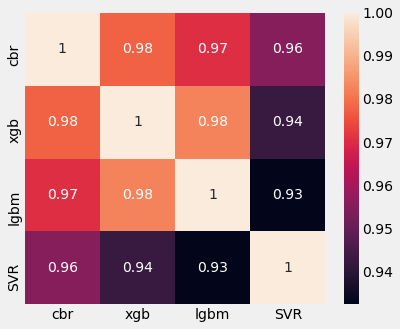

In [88]:
test_Survived_cbr = pd.Series(cbr_reg_best.predict(test), name="cbr")
test_Survived_xgb = pd.Series(xgb_reg_best.predict(test), name="xgb")
test_Survived_lgbm = pd.Series(lgbm_reg_best.predict(test), name="lgbm")
#test_Survived_ngb = pd.Series(ngb_reg_best.predict(test), name="ngb")
test_Survived_SVMR = pd.Series(SVMR_best.predict(test), name="SVR")


# Concatenate all classifier results
#ensemble_results = pd.concat([test_Survived_cbr,test_Survived_xgb,test_Survived_lgbm,test_Survived_ngb],axis=1)
ensemble_results = pd.concat([test_Survived_cbr,test_Survived_xgb,test_Survived_lgbm,test_Survived_SVMR],axis=1)

plt.figure(figsize=(6,5))
g= sns.heatmap(ensemble_results.corr(),annot=True)

## Voting

In [67]:
voting_reg = VotingRegressor(estimators=[('rfr', RFR_best), ('extr', ExtR_best), ('svr', SVMR_best), 
                ('adar',ada_best),('gbr',GBR_best)], n_jobs=-1)

voting_reg = voting_reg.fit(X_train, y_train)

In [68]:
y_pred = voting_reg.predict(X_train)
print(1-NMAE(y_train, y_pred))

print(y_pred[:15])
print(y_train)

0.8702919765319158
[11.78796565  7.32063236 14.06173777 11.28549471  6.49814372 11.0329966
  9.33952496 11.4596322  10.32519634  8.623083   11.11803291  7.54755786
 13.61787221  9.69464868 10.92575166]
0       15
1        8
2       18
3       13
4        6
        ..
1248     4
1249     7
1250     7
1251     6
1252    11
Name: Target, Length: 1253, dtype: int64


In [89]:
voting_reg2 = VotingRegressor(estimators=[('cbr', cbr_reg_best), ('xgb', xgb_reg_best), ('lgbm', lgbm_reg_best), 
                ('svr',SVMR_best)], n_jobs=-1)

voting_reg2 = voting_reg2.fit(X_train, y_train)

In [91]:
y_pred2 = voting_reg2.predict(X_train)
print(NMAE(y_train, y_pred2))

print(y_pred2[:15])
print(y_train)

0.12354063958601331
[12.13976003  7.30475381 14.57416879 11.40118681  6.50566441 11.78970987
  9.43764085 11.65885288 10.31113629  8.49038942 11.05124081  7.41730462
 14.79731318  9.3553325  11.14463692]
0       15
1        8
2       18
3       13
4        6
        ..
1248     4
1249     7
1250     7
1251     6
1252    11
Name: Target, Length: 1253, dtype: int64


# 4. 추론 (Inference)

모델 학습이 완료되었다면, 이제 test 데이터를 통하여 전복나이를 예측해보겠습니다.

In [85]:
test_Survived = pd.Series(voting_reg.predict(test), name="Survived")

test_Survived

0        9.190154
1       12.907050
2        5.475520
3       11.145163
4       10.123027
          ...    
2919     4.124248
2920     7.433949
2921     9.395569
2922     9.081672
2923    11.975315
Name: Survived, Length: 2924, dtype: float64

In [86]:
voting_reg.fit(X_train, y_train)
y_pred = voting_reg.predict(X_train)

mean_absolute_error(y_train, y_pred)

1.283562022217501

In [92]:
test_Survived2 = pd.Series(voting_reg2.predict(test), name="Survived")

test_Survived2

0        8.998602
1       13.505856
2        5.619820
3       11.022426
4        9.981649
          ...    
2919     3.985869
2920     7.319221
2921     9.387044
2922     8.876062
2923    11.548243
Name: Survived, Length: 2924, dtype: float64

In [80]:
test_Survived3 = pd.Series(ngb_reg_best.predict(test), name="Survived")

test_Survived3


0        9.055887
1       13.616774
2        5.556275
3       10.617842
4       10.164607
          ...    
2919     4.050873
2920     7.192560
2921    10.015005
2922     9.398338
2923    11.320181
Name: Survived, Length: 2924, dtype: float64

In [81]:
ngb_reg_best.score(X_train, y_train)

1.3736964191784864

# 5. Dacon 대회에 제출하기 (Submission)

이제 이 예측 결과를 submission.csv 파일로 만들어서 대회 페이지에 제출해보도록 합시다.

제출한 뒤 리더보드를 통해 결과를 확인합시다.

In [93]:
# 제출용 Sample 파일을 불러옵니다
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,id,Target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [94]:
submission['Target'] = test_Survived2

# 데이터가 잘 들어갔는지 확인합니다
submission

,id,Target
0,1,8.998602
1,2,13.505856
2,3,5.619820
3,4,11.022426
4,5,9.981649
...,...,...
2919,2920,3.985869
2920,2921,7.319221
2921,2922,9.387044
2922,2923,8.876062


In [95]:
submission.to_csv('data/submission_voting2.csv', index=False)